In [1]:
import matplotlib.pyplot as plt # pyright: ignore[reportMissingModuleSource]
import pandas as pd # pyright: ignore[reportMissingModuleSource]
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import requests
import io
from pathlib import Path
from nltk.tokenize import word_tokenize
import tarfile
from gensim.models import FastText
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer


nltk.download("stopwords")
nltk.download('punkt_tab')

stop_words = set(stopwords.words("english"))

%cd ..

/home/kalisto/Documents/info_search_spbu_2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/kalisto/Documents/info_search_spbu_2025


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kalisto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/kalisto/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
data = pd.read_json("data/arxiv_attention_is_all_you_need_data.json")
data["published"] = pd.to_datetime(data["published"])
data["updated"] = pd.to_datetime(data["updated"])
data.info()
df = data.copy()
df["id"] = data["id"].str[21:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2305 entries, 0 to 2304
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         2305 non-null   object             
 1   title      2305 non-null   object             
 2   summary    2305 non-null   object             
 3   published  2305 non-null   datetime64[ns, UTC]
 4   updated    2305 non-null   datetime64[ns, UTC]
 5   authors    2305 non-null   object             
dtypes: datetime64[ns, UTC](2), object(4)
memory usage: 108.2+ KB


In [3]:
data_attn = pd.read_json("data/arxiv_attention_is_all_you_need.json")
data_attn["published"] = pd.to_datetime(data_attn["published"])
data_attn["updated"] = pd.to_datetime(data_attn["updated"])
data_attn.info()
df_attn = data_attn.copy()
df_attn["id"] = df_attn["id"].str[21:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         1 non-null      object             
 1   title      1 non-null      object             
 2   summary    1 non-null      object             
 3   published  1 non-null      datetime64[ns, UTC]
 4   updated    1 non-null      datetime64[ns, UTC]
 5   authors    1 non-null      object             
dtypes: datetime64[ns, UTC](2), object(4)
memory usage: 180.0+ bytes


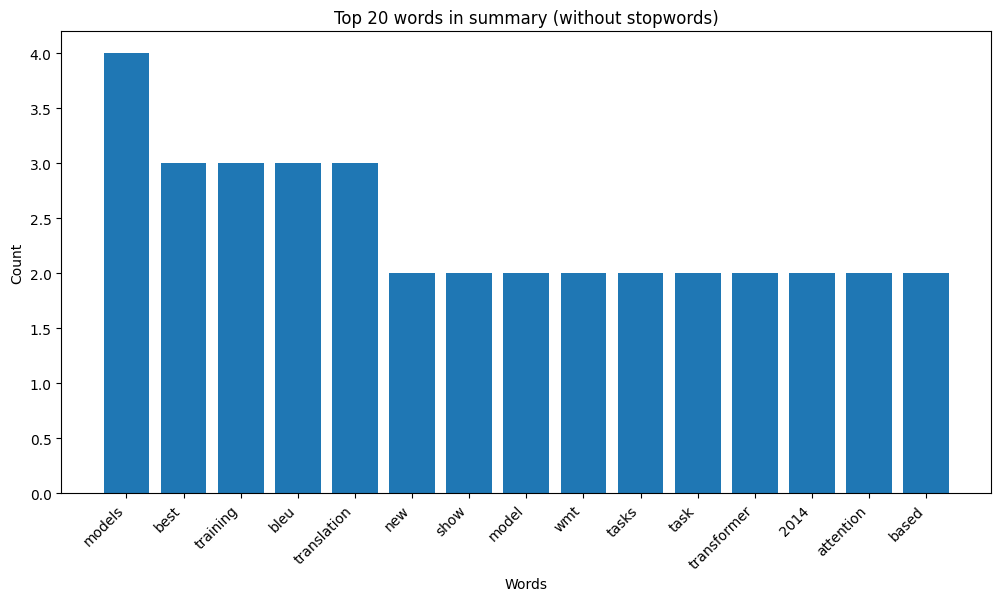

In [4]:
series_ref = df_attn[df_attn['id'] == '1706.03762v7'].iloc[0]
series_ref = series_ref.replace({r'[":/*#$@,.()]': ''}, regex=True)
series_ref = series_ref.replace({r'[\n]': ' '}, regex=True)
series_ref = series_ref.str.replace(r'http\S+|https\S+|[,.\n]', '', regex=True)
series_ref = series_ref.str.lower()
stop_words = set(stopwords.words("english"))

text = series_ref["summary"]
words = [w for w in text.split() if w not in stop_words]

word_counts = Counter(words)
df_words = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)

top_n = 15
top_words = df_words.head(top_n)

plt.figure(figsize=(12,6))
plt.bar(top_words["word"], top_words["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Top 20 words in summary (without stopwords)")
plt.show()

top_words_dict = dict(zip(top_words["word"], top_words["count"]))

In [5]:
df["top_words_dict"] = pd.Series([{}]*len(df), index=df.index, dtype=object)

for idx in df.index:
    summary = df.at[idx, "summary"]
    summary = re.sub(r'http\S+|https\S+|[,.\n":/*#$@()]', '', summary)
    summary = summary.lower()
    words = [w for w in summary.split() if w not in stop_words]
    top_words = dict(Counter(words).most_common(15))
    df.at[idx, "top_words_dict"] = top_words

In [6]:
df.shape

(2305, 7)

In [7]:
series_ref

id                                                 170603762v7
title                                attention is all you need
summary      the dominant sequence transduction models are ...
published                                                  NaN
updated                                                    NaN
authors                                                    NaN
Name: 0, dtype: object

In [15]:
def get_doc_vector(text, model):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)


def find_similar_texts(df, series_ref, data, top_n=5, top_k=50, vector_size=100):
    sentences = [text.split() for text in df["summary"]]
    model = FastText(sentences, vector_size=vector_size, window=5, min_count=1, epochs=10)
    
    X = np.array([get_doc_vector(text, model) for text in tqdm(df["summary"], desc="Vectorizing")])
    ref_vector = get_doc_vector(series_ref["summary"], model).reshape(1, -1)
    
    similarity_matrix = cosine_similarity(ref_vector, X).flatten()
    similarities = similarity_matrix.copy()
    similarities[df.index.get_loc(series_ref.name)] = -1
    
    top_pos = similarities.argsort()[-top_k:][::-1]
    top_scores = similarities[top_pos]
    top_idx = df.index[top_pos]
    
    print(f"Reference:\nTitle: {series_ref['title']}\nLink: {data_attn.loc[data_attn.index[0], 'id']}\n")
    
    for k, (idx, score) in enumerate(zip(top_idx, top_scores), 1):
        if k <= top_n:
            print(f"{k}. Idx: {idx}\nTitle: {df.loc[idx, 'title']}\nCosine similarity: {score:.3f}\nLink: {data.loc[idx, 'id']}\n")
            
    return top_pos, top_scores, top_idx

top_pos, top_scores, top_idx = find_similar_texts(df, series_ref, data)

Vectorizing: 100%|██████████| 2305/2305 [00:00<00:00, 10512.55it/s]

Reference:
Title: attention is all you need
Link: http://arxiv.org/abs/1706.03762v7

1. Idx: 163
Title: Quantum Graph Transformer for NLP Sentiment Classification
Cosine similarity: 0.973
Link: http://arxiv.org/abs/2506.07937v1

2. Idx: 1002
Title: TreeGPT: Pure TreeFFN Encoder-Decoder Architecture for Structured
  Reasoning Without Attention Mechanisms
Cosine similarity: 0.962
Link: http://arxiv.org/abs/2509.05550v2

3. Idx: 1815
Title: Encoding Syntactic Knowledge in Transformer Encoder for Intent Detection
  and Slot Filling
Cosine similarity: 0.960
Link: http://arxiv.org/abs/2012.11689v1

4. Idx: 126
Title: Weighted Transformer Network for Machine Translation
Cosine similarity: 0.960
Link: http://arxiv.org/abs/1711.02132v1

5. Idx: 199
Title: Cross-Attention Speculative Decoding
Cosine similarity: 0.959
Link: http://arxiv.org/abs/2505.24544v3



In [9]:
def clean_text(raw_text:str) -> str:
    """ Remove LaTeX commands and comments """
    # Remove comments
    text = raw_text
    text = re.sub(r'%.*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'[0-9]', '', text)
    
    # Remove LaTeX commands (e.g., \textbf{...}, \cite{...})
    text = re.sub(r'\\[a-zA-Z]+\{[^}]*\}', '', text)
    text = re.sub(r'\\[a-zA-Z]+\[.*?\]', '', text)
    text = re.sub(r'\\[a-zA-Z]+', '', text)
    
    # Remove special LaTeX characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'_', '', text)
    
    # Remove multiple spaces and newlines
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'\n\n+', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'\\', '', text)
    text = re.sub(r' +', ' ', text)
    
    text = text.lower().strip()
    
    text = ' '.join([word for word in text.split() if 2 <= len(word) <= 6])
    
    return text

def tokenize_article(raw_text:str) -> list:
    """
    Takes raw article text and returns tokenized text.
    
    Args:
        raw_text (str): Raw article text (typically LaTeX from arXiv)
    
    Returns:
        str: Space-separated tokenized words
    """
    text = raw_text
    
    text = clean_text(text)
    
    
    # Tokenize
    tokens = word_tokenize(text)
    
    return tokens

In [ ]:
def process_arxiv_paper(k: int, idx, df, score: float, arxiv_url: str, is_reference: bool = False) -> list:
    """
    Process an arXiv paper: download, extract, clean, and tokenize.
    
    Args:
        k: Result number (for display)
        idx: Paper index
        df: DataFrame containing paper metadata
        score: Cosine similarity score
        arxiv_url: URL to the arXiv paper
        is_reference: If True, display as reference paper (default: False)
    """
    if is_reference:
        #print(f"Reference:\nTitle: {df.loc[idx, 'title']}\nLink: {arxiv_url}")
        pass
    else:
        #print(f"{k}. Idx: {idx}")
        #print(f"Title: {df.loc[idx, 'title']}")
        #print(f"Cosine similarity <summary>: {score:.3f}")
        #print(f"Link: {arxiv_url}")
        pass
    
    try:
        src_url = arxiv_url.replace('/abs/', '/src/')
        
        response = requests.get(src_url, timeout=30)
        response.raise_for_status()
        
        tar_file = tarfile.open(fileobj=io.BytesIO(response.content), mode='r:gz')
        
        # Find all .tex files
        tex_files = [member for member in tar_file.getmembers() if member.name.endswith('.tex')]
        
        if tex_files:
            # Extract and read all .tex files
            raw_text = ""
            for tex_file in tex_files:
                f = tar_file.extractfile(tex_file)
                raw_text += f.read().decode('utf-8', errors='ignore') + "\n"
            
            clear_text = clean_text(raw_text)
            tokenized_text = tokenize_article(raw_text)
            
            #print(clear_text)
            #print(tokenized_text)
            
            return tokenized_text
        else:
            print("No .tex file found in archive")
        
        tar_file.close()
        
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {src_url}: {e}\n")
    except tarfile.TarError as e:
        print(f"Error extracting tar file: {e}\n")
    except Exception as e:
        print(f"Error parsing content: {e}\n")

In [ ]:
ref_tokens_list = process_arxiv_paper(0, series_ref.name, df, 0, data_attn["id"].iloc[0], is_reference=True)

k = 0

for idx, score in tqdm(zip(top_idx, top_scores), total=len(top_idx), desc="Processing papers"):
    k += 1
    if k < 5:
        arxiv_url = data.loc[idx, 'id']
        tokens_list = process_arxiv_paper(k, idx, df, score, arxiv_url)
    

the goal of also forms the of the neural gpu and convss all of which use neural as basic block hidden in for all input and output in these models the number of to relate from two input or output grows in the for convss and for this makes it more to learn in the this is to number of albeit at the cost of due to an effect we with as in called is an of single in order to of the has been used in of tasks and memory are based on of and have been shown to well on and tasks to the best of our the is the first model on to of its input and output using rnns or in the we will the and its over models such as and neural long memory and gated neural in have been firmly as state of the art in and such as and have since to push the of models and models factor along the symbol of the input and output the to steps in time they of hidden states ht as of the hidden state ht and the input for this nature within which at longer as memory limit across recent work has in tricks and while also model in case o

Processing papers:   2%|▏         | 1/50 [00:00<00:33,  1.47it/s]

acmart make sure to enter the title from your rights ny is for more and models in where data is we the graph qgt hybrid that into the for the is using pqcs which enable the model to rich while the number of to we qgt on five show that qgt higher or than qnlp models both and when with an graph qgt yields an of these the of qnlp for and ccs ccs ai has become an part of modern such as and nlp plays role in ai by to and human this allows nlp to power of from to agents and recent in nlp models such as gpt have to and text their nlp models still face and for models large of data access to hpc and the of of qml is for some of the with ml models qml adopts hybrid in which data is into space and is using pqcs which act as layers to neural layers in these such as and to more in the of nlp where tokens is qml offers for more and models nlp qnlp models have the to in sample model speed and recent in qnlp have to into early models the vector qsvms and more recent have on hybrid such as lstms based 

Processing papers:   4%|▍         | 2/50 [00:01<00:35,  1.35it/s]

visual task three task types with the hybrid design with tree study the of flow the with global study across with on arc prize etal etal etal etal etal etal etal etal we an neural that the of pure design for tasks unlike that rely on that in aiming to while our on where the while the both using simple this design while we our on the arc prize where the rapid of large models llms has made deep key for model cot dsl and mamba while on tasks still face when tasks those syntax tree ast often suffer from and when long and to these we novel hybrid that with global to in ast we that pure design for tasks our where and in using on arcagi that the of deep clear from global to more this an trend toward biases that better align with the of tasks those syntax tree the by et al as the of modern deep its to and enable the and have made it the for across when with such as code and data the while for to the in often that to the of cot that into steps this model by making the and human while cot in the

Processing papers:   6%|▌         | 3/50 [00:04<01:16,  1.63s/it]

we novel with for intent and slot we encode into the by it to parse and of each token via our model is based on and layers and does not to be at time show that on two our models with only two layers to the best model our models score and of in this paper we to encode into the model for intent and slot that model with only two layers can match or even the sota on two we show that the of this model can be by the of the also that can help the model to better learn for future work we will our with larger model sizes on larger scale more we will into models by and those models on the nlu tasks we on two the travel atis and snips the atis has focus on and has been used as on nlu tasks we used the same as that for for and for the snips has focus on with larger size and more and slots it for for and for we use for intent and the score for slot which is the of and recall for the snips we use the same and method as works for the atis we that works two for intent on with labels the first method c

Processing papers:   8%|▊         | 4/50 [00:04<00:57,  1.25s/it]

on neural often use models with some form of or new that avoids and it uses only and layers while the on tasks it large number of and to we with layers that not only the in bleu score but also we the by that the model learns to during the our model the by bleu points on the wmt task and by on the task neural rnns such as long memory lstms form an block for many tasks that of data rnns have been for such tasks speech and rnns make output at each time step by hidden state vector ht based on the input token and the states this their to map pairs of their of hidden states to be before the time step they cannot from of that use eschew the based in these models the needed to learn can be to learn often used in with models have become an part of tasks they of such in the the novel that avoids the and maps the input into hidden states solely using the use in with this allows for and time to the report for neural that show the on the wmt and tasks while being faster than prior still large numbe

Processing papers:  10%|█         | 5/50 [00:05<00:48,  1.07s/it]

manasa yixiao wang nikhil verma yipeng ji chul lee sd is widely for in large models llms when the draft and target models are well sd rely on often with or fusion layers this makes them and harder to across models we budget eagle beagle the first to our sd model that on par with sd models eaglev while the need for or the and stable memory usage during to enable of this novel we new method that and in across llms and show that beagle and higher than eaglev strong for in sd is an method for in large models llms where draft model the next tokens in the need for target model the of sd has been in due to its to in both greedy and while also of idle during phases sd often draft models with ones that are the target model to match its output better as result the design and of sd models pose both and from an draft model an open nearly as as the target llm itself draft model must the target models token while much for toward this goal range of has been from mlps or ffns to to more heads which ha

Processing papers:  12%|█▏        | 6/50 [00:06<00:44,  1.01s/it]

have the in nlp in recent years but very large and we that the design of model on large in manner and it for tasks leads to models that are highly both and we that to create models for given task two key and hard and parts of the that hinder on the given task sparse blocks in layers by word the model focus only on the parts of the input in effect leads to models that are more while also being faster and our on glue and squad tasks show that models are up to the use of prior about tasks is only to help reduce the of all the exact in this paper can be the use of this prior prior has shown that the in layers can be into three main in bottom layers the layers to the input and in the middle layers and in the top layers these into the inner of models we all of these for table we create models each with in orders then the model with loss is chosen as the final model for the of the model is worst when the blocks the most are first bottom layers for see since these blocks may get pruned simply 

Processing papers:  14%|█▍        | 7/50 [00:08<00:58,  1.37s/it]

li yi iiis qi zhi cvpr cvpr cvpr rgb gray ex todo rgb hybrid have broad these can the of while on mambas in and the of such hybrid an open such as masked mae or ar focus on in for hybrid must be for both mamba and based on this we masked map to hybrid vision this the of both mae and the of mamba and within show that the hybrid vision with map other we the on both and and to the design for each code and are at the has it the of and mambas strong in to scale up vision an is for the of mamba and our work aims to take the first step in this asked to the hybrid it on both and tasks its core lies in the masked tokens based on the tokens to build global it on and its has been in the field of large models our method first masks the input image and then the image in manner this in of local and the local making it highly with the hybrid we found mae is better suited for while ar is more with mamba map on the other hand is more suited for the map also when with pure mamba or pure the and broad of

Processing papers:  16%|█▌        | 8/50 [00:11<01:13,  1.75s/it]

subfig xcolor tian ye yun liu erkang chen shell sample using for ieee image have with cnns how to such an open in this work we whose is to the global of and the local of in an with local in the and the we only adopt novel hybrid block in the latent layer to model the in and handle the uneven such design the in image and on image tasks that db gain over the maxim method on the indoor for single image while image local hybrid module has been made in image via cnns image image and the local bias and of the bestow cnns the of local lack global to this adopt to obtain larger field and the of cnns is still due to the lack of global mprnet the image which the image based on cnns kit of the knn block which the by the our adopts the block in part and embeds the hybrid block into the latent layer to reduce csd and indoor the best on and still costs much less than others by the nlp vision was in the tasks and many works such as cvt levit mpvit vision to model and has shown great in vision tasks t

Processing papers:  18%|█▊        | 9/50 [00:11<00:58,  1.43s/it]

on google we show that can be sped up with costs by the with simple linear that mix input tokens most we find that the in with the has rapid and in nlp at its heart is an bias that each token in the input basis of every other token many papers have and probed the and in the in an effort to better the see for in their these probes back the that by higher order units to form out of of the input models can and in this work we token mixing can wholly the layers in we first the with two matrix one mixing the and one mixing the hidden seeing in this simple linear mixing scheme we the of faster linear we find that the having no at all nearly the same as dense linear mixing and scales very to long inputs on gpus owing to the fast fft we call the model fnet while have been used to or speed up in neural neural and mlp layers more we our work is the first to wholly neural with this of the as first class mixing is of the for vision which with mlps in to fnet has no that mix along the given the of 

Processing papers:  20%|██        | 10/50 [00:12<00:47,  1.20s/it]

model lm has in and sample on of tasks it how to best use lms for tasks such as to sample in these prior work has with into the andor but used we use where the same lm both the source and the this that all in the those over source states have been before the step on the mail show that our lm over in for it rouge using only acl second author line line line this the for for the of acl the itself to its own and is an of what your should look like these should be used for both papers for review and for final of papers are asked to to all the in this this has been from the for acl and naacl those for naacl by lukin and alla acl by shay cohen kevin gimpel and wei lu naacl by and lukin naacl bibtex from jason eisner acl by dan gildea and minyen kan naacl by acl by maggie li and white those from acl by chang and koehn those for acl by moore simone teufel james allan and furui those for acl by hwee tou ng and kemal those for acl by eugene and dekang lin and acl and eacl those were by people joh

Processing papers:  22%|██▏       | 11/50 [00:13<00:39,  1.02s/it]

large models llms have made in tasks yet they remain by two core due to on and lack of for we an model that both issues and built on the state space dual ssd layers of mamba our model the need for and to train it for we based on the which via and on strong and hybrid models of scale and even the much larger gemmab by recent in large models llms has in and code these in the that powers most llms their is and scales poorly with long input kv cache during in linear memory growth and in this has become with the rise of long by models like and where paths are for in this work we an model that and fixed memory per token kv cache yet strong and hybrid models of the much larger gemmab by this of with to solve tasks while to across math and code show that our model strong of size and even larger models on such as aime and this paper makes the key we fully model that strong and hybrid of sb by which the model to we that the on all math higher on gb memory and on gb memory to strong its for in we

Processing papers:  24%|██▍       | 12/50 [00:13<00:34,  1.09it/s]

junhao xu liu hu zi ye neural models lms by are highly their use of fixed fail to for model and lead to and poor when given data in order to these issues this paper full for lm based are used to the latent with parts of the model feed and layers word error rate wer up to neural models model speech models lms play an role in speech asr and many other models the joint of given wt as wntn wt wt which can be using the of word level the key part of the is to learn lead to severe data for ngram models to this end neural models that can longer span in vector space for based on term memory neural can be used in recent years deep models have across range of speech tasks the model deep of layers with and layer to learn layers are used to the layers with order over the models have been widely the highly neural design of often leads to large in the system for up to of of in common with other deep based the use of fixed in models fails to for model when given data models are prone to and poor this 

Processing papers:  26%|██▌       | 13/50 [00:14<00:30,  1.22it/s]

Error extracting tar file: not a gzip file



Processing papers:  28%|██▊       | 14/50 [00:15<00:28,  1.28it/s]

llncs to in vision for image john we that vision qvits vision vits with sa by qsa can match sota image while using vision vits have as in vision by images as of and sa to and within image data vits have for tasks often neural cnns their with in sa layers limit in qml offers to the by neural qnns that within spaces qml rich in spaces qml has with surge of in image where the power qnns to data with to more for tasks vision qvits merge vits and qml by the linear in vits sa with qnns qsa this the sa from to while power within the space whilst into qvits is still in its stages recent work has shown these can with models using vastly fewer kd which rich from large models to offers to qvit that is in the while kd has proven for vits its to qvits this gap is in where model is for we the of qvits vits across eight of binary and tasks and an task we the of models both from and with kd from model under range of we make the we the first into the of qvits with kd for image that scales with in the q

Processing papers:  30%|███       | 15/50 [00:15<00:25,  1.36it/s]

left center right top bottom figure figure and and and and and and part part parts and msl lp pa argmax argmin sign tr natbib yiren zhao london and of ilia of oxford robert of along with show how we are the the tasks we our on are given in with on the used for in the main body of our code can be found at hbt since have become due to their over such as neural rnns and even neural cnns many new have also been that on the by its on length by more little has been done on the of the size of the in each layer the number of layers and how these relate to the the source of in is the ffn in each or layer and the linear layers which from the often equal to the to the and back again after is each head has an equal number of an input where is the length and is the here with heads is used and each head on the with of after the there is ffn with single hidden of size these layers are then times as on the left of often in eah the total number of in is given by leah ahe em me leah in this paper we the

Processing papers:  32%|███▏      | 16/50 [00:18<00:48,  1.41s/it]

xcolor rgb dept of comp sci tech for ai bnrist center joint ml center thbi lab char rgb rgb the across models as the heart of the has of on to on for linear when large the has proven to be an method for model focus on the linear layer in we first the of in that we highly and method for the ops per second of our and by about and also over that our incurs almost those for large image and video the code is at left center right top bottom figure figure and and and and and and part part parts and msl lp pa argmax argmin sign tr in this we fast yet method to with bit that most are not with is to be unlike linear layers which are easy to is more extra is to ensure both good and fast speed first we will in by our based on the of and in and we the as qk km pv is to obtain which we shall in for we omit all and but the used in are still tiles and the is still as in to the as shown in eq adds to qkpv and to the to both of qk and pv online is left in htb htb with quant often in large error to int y

Processing papers:  34%|███▍      | 17/50 [00:19<00:39,  1.21s/it]

arxiv argmin argmax school of of and of china ustc china school of ustc china data lab center suzhou for ustc china in equal author impact this paper work whose goal is to the field of there are many of our work none which we feel must be here large models have but face of high and costs due to the on the large kv cache for recent to reduce kv cache size by less based on remain and lack formal this paper formal study on kv cache by output our that beyond the value states within kv and are also based on this we that the output to on the test and show our cache that our lower output in over we our in output using the which the hidden states of the first third and fifth tokens with our output across all in the llama model lower in figure shows how our across layers to in the final layer which the token figure that our method lowers output across cache sizes from these that our method output by by this in the output hidden states that are more with those from the full kv cache and loss rgb

Processing papers:  36%|███▌      | 18/50 [00:20<00:41,  1.29s/it]

xcolor ulem tr in this work are and in detail by the neural known to be very in and image upon the work which uses for data and neural layers we three types of for and based on which of the to their both in terms of run time and the number of model these can be built using and models the three layers vary on the the and more as blocks of the we novel method for matrix as states as well as two new layers to levels of and of we of the on image that showed and at times better to the the vision we our on and for up to six qubit uses in order to novel and tools to the of some use to neural and space while others native to such as or shows the global of vision first the image is using patch fig and then layers are see in fig and fig the final step in simple fully neural for in this work we focus on neural by which has been to both and visual tasks across tasks and of these can be found in works such in the realm of neural in works neural hinted at the of which can be found in at high level a

Processing papers:  38%|███▊      | 19/50 [00:21<00:34,  1.10s/it]

natbib fermi il sahu elham khoda javier duarte of san diego la jolla ca ml models have become for the vast data by like atlas and cms at the cern lhc part model to tasks which are for from proton this study on part by heat maps and on the plane binary where each to at most one other at the same time we that part shows focus on and on decay that the model learns jet these our of the models and for the of in future ml are for the data by like atlas and cms at the cern lhc models with their to and weigh the of in input data have and vision the of the to in the spray of jets from decays has proven in for new and model of at lhc can create new which then decay and sprays of called jets which are by these jet or the of the that this spray is step in data at the lhc one such model for jet is part which is that or to the this is one of the best models there is effort to the and why the model so well the of may offer deeper into the inner of neural in the case of jet tagger the matrix the makin

Processing papers:  40%|████      | 20/50 [00:22<00:28,  1.04it/s]

natbib todo elango rgb models have as for and image tasks of the is which allows the model to within the data the also incurs and memory costs for long in this paper we novel that along two query and of the this method and of across our and phases to unlike that to scale with an number of units our scales with units our the of our method in and to ring our up to boost on model using nvidia gpus across nodes and up to boost on nvidia gpus across nodes models have shown in across wide range of ai and have as the of choice in such as and image are for array of ai books and images long videos and and ai the use of vastly has become trend for gpto has length of tokens while claude model length of tokens is key block of models is slow and for long this has surge of on down the memory and needs of models have that reduce the memory cost from to linear in terms of the length while little has been made in the cost the cost linear with to length of the number of units used for model with layers 

Processing papers:  42%|████▏     | 21/50 [00:23<00:30,  1.04s/it]

wacv xcolor gray derek jacoby of bc yvonne coady of bc we model for the of images this model uses with that global and local in the blocks uses layers which the model and the need to and codes which can reduce model when and image differ we simple for noisy input like clouds and that model can be by mhsa with na on the pastis and mtlcc crop type show that better than models and only is task in vision that class for each pixel rather than an this vision task is useful in remote for image time series sits data where it is to and in an of sits data is in crop types since crops events their growth cycle that can be in remote crop types has for tasks yields crop health food and more while the of in models input it can the of input data since the earths is by more than this paper an model that along the and uses gated to enable the while we show that mhsa can be with na which the number of point to to verify the of we use two namely the mtlcc and pastis both of which few and use data as inpu

Processing papers:  44%|████▍     | 22/50 [00:26<00:45,  1.62s/it]

htpb gan insgen hits hitb hitl ddpm ldm lfm udm and are on for we ran while most are built off of the models they may not all be able to the custom cuda which can ht cccc level kernel size size ht lcr fid diff na flips prog di ht ccl level kernel size ht lccr rgb rgb rgb rgb rgb rgb def super len for range len if else zip apply return init append true false none or torch module linear cat chunk shape zeros dim htbp class def dim int int float float none dim or for in dim if for in true else diff rpb for in for in false rshape for in rpb std mean for rpb in dim def xshape qkv qkv qk kv if dim dim dim else for in iih iih iih ih rpb for rpb in zipq for in for attn in return using natten may need code is for and clip ht ht ht ht clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip 

Processing papers:  46%|████▌     | 23/50 [00:27<00:35,  1.31s/it]

the is to models in gpt and bert the of models on nlp tasks using models on these are for model itself nor the in the is able to the to in this paper we for model adding lstm layers to better the while still the we search cas to find an of the model on the ptb and show that cas and on all ie on an of units to lstms the source code is we study the of an for model we the issues of such as bert and gpt that are not able to the strong in model we two to this issue we subset of to the from the models we add lstm layers to the we then search cas to select an based on it uses greedy search to search we show that cas the models on three model we only show the of cas when to the model task we feel it is to apply cas to both other neural and other nlp tasks that strong as well our are based on gpt and bert we will reuse the in gpt and bert to the model task during we modify and the and used by gpt and bert to adapt to model task gpt uses of the that is it based model the paper with layer blocks 

Processing papers:  48%|████▊     | 24/50 [00:27<00:28,  1.10s/it]

acl proof jm yadong xi jing ma zhiwei yang xiaoxi mao fan zhang of hong kong hong kong sar china fuxi ai lab inc china jilin jilin china since the models play roles in tasks common of the in is that it cannot the of word order so are to be fed into the target model in with the causal masks is to the word order in this work we focus on the of bert with the causal masks we new model and it on the glue show that the causal mask is for bert on the tasks our model on the glue and our the and better than the when with the same amount of in recent years model by has the lstm as an of many nlp there are two of model and the models eg bert and have great on many eg glue and the models such as have shown on all of them the since is as an the help of should share the same with the model on the other hand in the causal masks make the from that of the have proved that with such masks is not that is to word order it is that focus on the of bert to the of eg extra to trace the word order also that th

Processing papers:  50%|█████     | 25/50 [00:28<00:24,  1.00it/s]

tmlr system relies on models based models have shown in are and models which limit their to learn the of the system we this issue with vision for stcvit the time neural ode layers with to learn the over time the is as in the to model the we define loss for stcvit which the models for away from laws we stcvit nwp model and deep based models stcvit on degree hourly data and to models on data for global rely on based nwp models while highly these system tend to be slow with errors and high can be as which can be as pdes these pdes the of over time the of and these priors leads to more and models recent works have shown that using deep models as to model can lead to models vision by has one of such models only of input data and are in nature which limit their in the of system these models ignore the laws of our which is for in this work we the in vision vit which arise in where data is in form the and of data pose in we the model for not in the form loss we build upon the core ideas of neu

Processing papers:  52%|█████▏    | 26/50 [00:29<00:23,  1.02it/s]

snjnl remark pt asset in on ml models for asset or factor tasks such as have proved that some ml such as the mlp and random forest rf the models when they are as model frames of asset models the mlp models show great for coping with market such as the one caused by the covid having better and stock among the large us stocks the mlp model still has such as under the method of gkx high values and data noises as well as low as they are the neural nn value during data may cause bias for simply the stocks or may cause the bias and such as mean or median values also the of the data and the of if the values occupy of the data on the other hand the mlp models added with the models which the cost the mlp method the stocks which the cost if the of stocks or is in length it does not the effect among the stocks which is an aspect that the or of the model thus the is there an nn that the the issue higher and the model and to the neural nn neural and their or mlp to solve these issues for stock pric

Processing papers:  54%|█████▍    | 27/50 [00:31<00:27,  1.22s/it]

ying qin wenju xu andrés bur zhong wang of eecs of kansas ks usa of china key of and china oppo us center inc palo alto ca usa of and neck of kansas kansas city ks usa of cs on canada author vision have lot of since the of vision vit on vision tasks with vision the can these need to be on large and vision show on small when from with widely like note that the model was first for which denser than images to boost the of vision on small this paper to the input in the domain we by the in the domain using cosine dct the size of input while most and hence the as result resnet and its have been widely used in vision tasks in the recent decade due to its from bias layers on the other hand limit its to global vision vit as an to resnet in vision the by global with which shows better with resnet in like after on larger jftm the lack of in vit in worse on small with resnet to its on more data and try to add layers to none of them solve this by input as in from and the main and images is this us 

Processing papers:  56%|█████▌    | 28/50 [00:32<00:28,  1.29s/it]

author xiang dai manos of of csiro data sydney of athens of and greece centre for ai sparse models such as and big bird are to with long there are clear to these to the in terms of but hat models are vastly we and fully hat models that use by and them with models and hats in long tasks our best hat model models while using is the of single long in the length of of words eg of legal and or of long and chunks of texts eg qa and nli one to with long is to simply expand models bert of of etc but this is for long given the on to this have sparse such as of or of have been on of eg on local global andor tokens relies on hats that use by adhoc and of hat have been in the but the of such models is still vastly in this work we the of fully hats and aim to answer three main which of and layers in hats best what is the effect of hats to adhoc ie blocks during are there or of using hats to sparse such as and of of local and global that the of the model and thus can be to up to tokens local is wind

Processing papers:  58%|█████▊    | 29/50 [00:33<00:23,  1.12s/it]

daniil airi alexey of and models have set new across wide range of nlp tasks yet the of their ue often fall short in tasks either over basic or on costly models to common for ue in linear have only modest gains that model should be we tackle these by the of maps across heads and layers to assess model our from of the models we to across heads and layers our method ue on for and text more and for in models over the past few years models have become widely for in to these must meet memory and time they should also errors that occur with noisy and inputs common to and in such is to build hybrid system where model data and are by more model or human expert this hybrid system costs for while errors on the odd data and the of the the part is the models in its to deal with the data aim to the of for an in tasks is the output of the models layer as the and zero of this method it is not always of low in some more the of the models to the same input such of can be by minor in the model such as i

Processing papers:  60%|██████    | 30/50 [00:34<00:23,  1.17s/it]

xcolor rgb lemma remark ulem ptpt tan tan nguyen of of deep models have across and vision tasks while the core of has proven of data it has been that the of the matrix across layers its in this work we the and means nlm and the novel that uses in to the of nlm with and this the and reuse of in the the at each layer our method offers two key over slower decay of and and across data and tasks we the gains of our model over on tasks and image and on both clean and data the code is at and have state of the art across wide of tasks in and in within vision and they have also strong in from tasks to tasks with weak or no at the core of these models is the which learns tokens in an input by the of each token with to all others the then each token into of the of the other tokens with to the scores the scores among tokens and are key to the of the even though deep models have they are prone to the issue where all token become nearly as more layers are added this often to as the the to to this we

Processing papers:  62%|██████▏   | 31/50 [00:35<00:20,  1.09s/it]

llncs daniel moyer ellen grant polina juan elfar and mit ma usa and center boston boston ma usa school boston ma usa centre for image of and london uk center for and school boston usa for and mit ma usa of fetal brains from stacks of mr slices in the of almost and often severe motion is task that is highly to the of we novel method using on data which model stacks of mr slices as with the our model the slices and the of one slice using from other slices we also the volume to assist and update the volume and to on data show that our method lower error and better with with mri data are also to the of the model to the of under severe fetal motion of fetal brain from stacks of mr slices is an tool in fetal brain due to rapid and random fetal motion fetal mri are to fast such as the sstw that motion even with such fast fetal mri is still to motion to of slices in stack the delay slices due to safety on rate sar worsen the svr prior to of fetal brain is manual svr is in due to the of data sv

Processing papers:  64%|██████▍   | 32/50 [00:36<00:16,  1.07it/s]

cvpr xcolor markus lu of in video action reach many models are too for the with in this work we the of video for action we video and across and our study is the first to the of action models in depth across and train wide range of video under the same we into three and show that that are best at action models need more motion and block models incur too much our that video are not yet of action on par with and that the need to be to bridge this gap code to our will be made human action is the task of what action is being in video due to the high of videos models video to learn robust the of models needs to be high enough to model the nature of video data as result models is to long times on such as which over rgb images times more than the the has and models that are to train on as little as single gpu recent models show much in with the of video data they use to and model in space and time from the it is clear which of these models are the most it is less clear which of these models ar

Processing papers:  66%|██████▌   | 33/50 [00:37<00:19,  1.13s/it]

subfig hybrid and logit for vision in iot deep into iot faces of the high of vision vits with the of edge large models like the swin excel in plant by their gflops limits and them for models such as and tinyml would be for but lack the for to bridge this gap we hybrid that logit and from swin to model our method the of to and both class and focus on the images the show over cnns and prior with this work crop in and how we can attain on edge code and models will be made for after swin leaf vision smart mobile edge vision edge the of ai into vision has crop yield and the use of ai has the that rely on expert and manual they are often and prone to human error deep have as tools for plant neural cnns have been widely used for this in and plant cnns often to within images which are to in to the of cnns vision vits have gained of their to model and global in vision tasks image hence cnns new vit like the swin with and maps which makes them of local and global in images while swin in plant th

Processing papers:  68%|██████▊   | 34/50 [00:39<00:21,  1.35s/it]

xcolor icml mlp lnorm rgb rgb rgb gt vt gtibm vt gt tech tech ibm in do the rich of dits unique that their we novel method that the power of dit layers to maps that locate within images the of dit layers to highly the major that linear in the output space of dit layers yields maps to used maps even on image other on the works for image models and even to video our work the first that the of dits are highly to vision tasks like maps that the of in images we flux raw cross daam with sdxl and for clip dits with of that can be used to maps left an layer both and tokens right these layers the image to create set of tokens models have gained as the for of tasks these models random noise into images guided by and detail the of models our of their models as black boxes where the input and are but the that them are hidden from human work on ti models has on which prompt and image patch unet can maps that the of and have found in tasks like image the of more recent dits models have unets as the 

Processing papers:  70%|███████   | 35/50 [00:40<00:17,  1.15s/it]

rgb logits chou meta menlo park ca sai surya of of texas at austin sijia chen meta menlo park ca jiecao yu meta menlo park ca wang meta menlo park ca manzil zaheer meta menlo park ca rohan anil san ca recent work has shown that loss scales as power law with both model size and the number of tokens and that models model size and token count these laws assume an supply of data and apply in as modern large models rely on the that they are is less valid this shift the need for that token in this work we the use of the an that to an triton kernel we that the better token than for fixed token budget sized models their on tasks coding and logic we these gains by that the in the laws for and tasks to dot large models llms based on the have become to many gpt gpt gemini and llama the in these models has been guided by neural laws which loss the number of model and the volume of data key from this body of work is that model is not simply by model size but by both the number of and the amount of 

Processing papers:  72%|███████▏  | 36/50 [00:41<00:15,  1.14s/it]

xcolor em rgb rgb rgb cumsum float int vfmulb ulem pt pt pt pt pt char like gaudi has been to matrix for large models llms for ai tasks our that are not fully on such due to in like and in when long to these issues we an called that merges sparse and linear aims to the of the gaudi matrix engine mme and tensor cores tpc model kernel and an outer kernel for causal linear aiming to llm on gaudi shows that and model across tasks on the gaudi and gpus model cola sst mrpc fa stsb ps qqp fa mnli qnli rte big bird our rrr model top acc acc big bird rrr model ppl ppl big bird have the field of nlp and beyond the of sota across and vision broad and to across fields the of that their and at the heart of this issue is the memory and time on for of inputs as the to longer and build larger more models grows this the is by the trend model sizes and in of and to these such as intel gaudi amd versal acap ai aies units rdus and engine wse has as avenue for the of and of large models gaudi stand out for

Processing papers:  74%|███████▍  | 37/50 [00:42<00:16,  1.28s/it]

pair such as and is an task in these tasks can be as of the given query models have shown on pair tasks due to the of the as shown in the takes pair of query and as input and the them at each layer by the the text power the leads to costs when the number of is very large eg the will be times if there are this cost the use of these models in many to tackle this issue we called that speeds up the while the of the the by only from to the query few tokens and only at few layers this avoids query the of in and thus costs allows to the into dense and to store them to the we for pair on four to tasks of and the that better the and for of more than over the and and models have been to the on pair tasks as shown in figure the query and the to online in fast speed this is built upon the of models adjust by an such as stack of layers for the the query and the cached these still suffer from the high costs of the in this we the of the which by the times of query and the number of tokens and layers 

Processing papers:  76%|███████▌  | 38/50 [00:43<00:13,  1.11s/it]

cvpr url lpz yyf kai ma zhou liang kai chen zhang yunfei yang sklois of of china school of cyber of of china of boston usa has its in both nlp and vision cv tasks though other models are known to be to the attack which embeds in the model and the model when the are little is known such an attack is still valid on the models and if so it can be done in more manner in this paper we dbia novel attack the the of to and the using the we based on three ie vit deit and swin on two image tasks ie cifar and the that fewer our can embed with high rate and low impact on the of the victim our code is at the attack in dnns can cause model to the input with as the target label we use to denote the benign sample the mask and the the sample can be as below the label of the sample is as the target label yt then the can inject the into the target dnns with the weight values by the loss using both the benign db xy and the dp yt as lfx lf yt db yt dp the model will learn the and it with the target label a

Processing papers:  78%|███████▊  | 39/50 [00:44<00:10,  1.00it/s]

reza rahimi azghan taheri yaa eric kim gudur mohit malu owen thomaz giulia pavan turaga hassan state az usa of miami miami fl usa the of texas at austin austin tx usa is marked by blood levels bgls which can lead to health such as stroke and of bgls helps normal levels and to timely bgls blood is by such as diet and sleep blood to highly on the status in levels among people with and with in deep bgl using and sensor data an active area of model across in blood models leads to the in deep models to these we for and blood two and which in and an cross blood data with other and such as stress and heart rate with rates and their on robust the to into the model the module not only the models to retain prior but also boosts its we on the which and data with people with and those with type we the and of in as new are show that other models is by high blood levels from the not or of the body to the that is can be as type type and of these three type is the most common type of over and is to he

Processing papers:  80%|████████  | 40/50 [00:45<00:09,  1.09it/s]

vinay of bath vijay vision have been for image tasks there have been either based vit deit to the work in models or more based on layers fnet gfnet afno we that both and plays major role we this this work and that indeed and layers better we thus the novel for that and layers we that the allows the to the and it yields over other for it the top by in with the work by et al have gone on to the domain in the form of large models such as gpt and its and palm work the of to vision and other the main ideas retain much of the the could from that are to the task this work we aim to the for the image task using vision we show that the can the for this task tb the of for vision was first in the vision vit they made the of for images the could be used for images deit the the domain plays major role in of image and has been well by the this is by work by hubel and weisel that showed tuned simple cells in the visual cortex in it has been shown that the could the layers and by rao et al where they 

Processing papers:  82%|████████▏ | 41/50 [00:45<00:08,  1.12it/s]

guijin wang xia yang li sun of china aima china of school china of status can be the of lead ecgs this work with and as novel to this ecg of each lead are as and with the signal they form as method to reduce from with low two group both and our method allows for the of the of show that our yields better scores than other models or better than sota deep on two our work has the for signal and tasks ht cvd cause of death in the and of care have become for in and of can be the of lead ecgs more and the use of ecg have the of ecg data for but it has become for to the of data in these in recent years ecg has been based on deep models such as neural cnns long memory lstms and some of which report sota scores with ecg are paying to models which have very well in of fields due to in and to encode input with in recent study cnn layers and layers from ecg and of by were heart rate and bat the as input and all with the layer after swin blocks in this work we novel with called with and in this neur

Processing papers:  84%|████████▍ | 42/50 [00:46<00:06,  1.24it/s]

Error extracting tar file: not a gzip file



Processing papers:  86%|████████▌ | 43/50 [00:47<00:05,  1.35it/s]

recent have that the of on the task of obeys with model size over six orders of while their hinges on large of data and their and memory grow with length by these we memory unit based model that prior for and an on and on or better for memory and over three orders of we show that our new the same as with fewer tokens we also show that for the same amount of our model the loss over about as much as over lstms we that adding global our and the model even such as the have been in with data and have come to lstms and other in the domain of within and this allows them to fully such as gpus making on as large as gb in to are much better at to rnns and this allows them to take of much longer than the tokens of rnns like the lstm are that can be to wide of and one of the of such is the lack of which makes them on large of data to good factor is that the of the matrix which is of shape with being the length thus and memory grow with to the length in this work we way of these we base our on the 

Processing papers:  88%|████████▊ | 44/50 [00:47<00:04,  1.47it/s]

subfig argmin filesw pt pt plus ex gordon zexu pan le roux tf domain models speech while some sota models rely on rnns this means they lack the and of blocks given the of pure in other fields in this work we focus on the rnn from models while sota this work model with by the model uses ffns with layers of linear layers to local the focus on global we place two such ffns before and after to the we also novel for models on and show that the model meets or sota in with an speech the past decade has in speech thanks to in neural nns early work such as deep trains nns to tf masks in the domain in audio nns have by and which chunks the and local and global for is now one of the in ee more in the tf domain where and are done has shown models have the to better in as the fft window size is much longer than the kernel size of while have shown great in ee the sota model relies on rnns rnns have some such as memory cost in the is very since it cannot be in models have been in other fields of thei

Processing papers:  90%|█████████ | 45/50 [00:53<00:10,  2.16s/it]

xcolor rgb rgb lt gb hw to to togoo ai in we to video built on over space and time our method named adapts the to video by from of our study and that where and are within each block leads to the best video among the design the new design on action the best on and to our model is faster to train it can higher test at small drop in and it can also be to much longer video clips over one minute long code and models are at over the last few years the field of nlp has been by the of based on of their at among words as well as their such as the model the across wide range of tasks and word video shares with nlp first of all videos and are both as the of word can often be only by it to the other words in the it may be argued that atomic in need to be with the rest of the video in order to be fully thus one would expect the models from nlp to be highly for video as well in the video domain or still the core for across video tasks while has shown when on top of layers to the best of our no to us

Processing papers:  92%|█████████▏| 46/50 [00:58<00:12,  3.19s/it]

acl dtgs dtg dtg school of and center of vision and models aim to better syntax trees and while prior work has been on adding to we new class of model with bias with by masks the stack and arc with of token and when on of with trees better while with model also recent models that can better guide models our code is at models have shown strong on tasks and broad of tasks the great power of the it lacks the biases of which has been to way to such biases into is of by work of as that into rnns recent have on this method to the models by these are as models they model the of and their trees show that these models in and gain better the above on the of bias of the that has been used in all these models is based on trees and it is of the of models from which model focus more on the tokens which is to the in at the two in this paper we models that learn joint of and trees an bias of to by of of ii the stack in of masks iii the stack of of stack depth and iv of head token and line of work in t

Processing papers:  94%|█████████▍| 47/50 [00:59<00:07,  2.43s/it]

Error extracting tar file: not a gzip file



Processing papers:  96%|█████████▌| 48/50 [01:00<00:04,  2.02s/it]

ulem em jiaze xiao zhang hao sheng and cheng of george dc usa ejiaze school of and china school of and time series is key in many and and neural rnn based models have on time series tasks most of the focus on by based on which often suffer from as the and other models have its great of long term we two based for time series which can train across tasks we of with an public which is by all data of all tasks on number of time series tasks show that our can not only the but also the method time series time series ie the of time series data from tasks is within both time series and in to time series users with access to across time series paths them to their in in the future the of time series can many such as stock prices in iot and many others in recent years with the rapid of the of things iot of mobile have data and bring many novel that can change human life these data can bring such as based on of data health status etc from have access to of data as shown in fig in this all the base

Processing papers: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]

cvpr xcolor rgb ptpt li chen shiyi lan zuxuan wu yugang jiang sernam lim fudan of meta ai equal built on top of vision have on of vision tasks while they still cost that scales up as the of heads and blocks in this paper we argue that due to the large among images their need for differ to this end we adavit an that learns to derive usage on which heads and blocks to use the on basis aiming to of vision with drop of for image with in an manner is to the to on that our method more than on to vision with only the for of nlp tasks have been an in the vision since the of the vision vit built on top of are of among from input images which is one of the main that they cnns in vision tasks from image to object action and so forth the in vision adavit learns to usage on which heads and blocks to the for image fewer are for easy top while more are used for hard bottom the cost with drop of green are in both recent on vision adopt the from nlp with taking of sliced image to as inputs the of block

In [20]:
model = SentenceTransformer('all-mpnet-base-v2')

try:
    ref_tokens_list = process_arxiv_paper(0, series_ref.name, df, 0, data_attn["id"].iloc[0], is_reference=True)
    ref_text = ' '.join(ref_tokens_list)
    ref_embedding = model.encode(ref_text)
except Exception as e:
    print(f"Error processing reference paper: {e}")
    ref_text = ""
    ref_embedding = None

similarity_results = []
skipped_count = 0

texts_to_compare = [ref_text] if ref_text else []
metadata = []

for k, (idx, score) in enumerate(tqdm(zip(top_idx, top_scores), total=len(top_idx), desc="Processing papers"), 1):
    try:
        arxiv_url = data.loc[idx, 'id']
        tokens_list = process_arxiv_paper(k, idx, df, score, arxiv_url)
        article_text = ' '.join(tokens_list)
        
        texts_to_compare.append(article_text)
        metadata.append({
            'df_idx': idx,
            'arxiv_url': arxiv_url,
            'summary_score': score,
            'title': df.loc[idx, 'title']
        })
    except Exception as e:
        print(f"Error processing paper {idx}: {e}")
        skipped_count += 1
        continue
    
if len(texts_to_compare) > 1:
    # Вычисляем embeddings для всех текстов
    all_embeddings = model.encode(texts_to_compare)
    ref_embedding = all_embeddings[0]
    article_embeddings = all_embeddings[1:]
    
    # Вычисляем cosine similarity
    similarities = cosine_similarity([ref_embedding], article_embeddings)[0]
    for meta, sim_score in zip(metadata, similarities):
        similarity_results.append({
            **meta,
            'total_score': sim_score
        })

the goal of also forms the of the neural gpu and convss all of which use neural as basic block hidden in for all input and output in these models the number of to relate from two input or output grows in the for convss and for this makes it more to learn in the this is to number of albeit at the cost of due to an effect we with as in called is an of single in order to of the has been used in of tasks and memory are based on of and have been shown to well on and tasks to the best of our the is the first model on to of its input and output using rnns or in the we will the and its over models such as and neural long memory and gated neural in have been firmly as state of the art in and such as and have since to push the of models and models factor along the symbol of the input and output the to steps in time they of hidden states ht as of the hidden state ht and the input for this nature within which at longer as memory limit across recent work has in tricks and while also model in case o

Processing papers:   2%|▏         | 1/50 [00:00<00:31,  1.57it/s]

acmart make sure to enter the title from your rights ny is for more and models in where data is we the graph qgt hybrid that into the for the is using pqcs which enable the model to rich while the number of to we qgt on five show that qgt higher or than qnlp models both and when with an graph qgt yields an of these the of qnlp for and ccs ccs ai has become an part of modern such as and nlp plays role in ai by to and human this allows nlp to power of from to agents and recent in nlp models such as gpt have to and text their nlp models still face and for models large of data access to hpc and the of of qml is for some of the with ml models qml adopts hybrid in which data is into space and is using pqcs which act as layers to neural layers in these such as and to more in the of nlp where tokens is qml offers for more and models nlp qnlp models have the to in sample model speed and recent in qnlp have to into early models the vector qsvms and more recent have on hybrid such as lstms based 

Processing papers:   4%|▍         | 2/50 [00:01<00:34,  1.38it/s]

visual task three task types with the hybrid design with tree study the of flow the with global study across with on arc prize etal etal etal etal etal etal etal etal we an neural that the of pure design for tasks unlike that rely on that in aiming to while our on where the while the both using simple this design while we our on the arc prize where the rapid of large models llms has made deep key for model cot dsl and mamba while on tasks still face when tasks those syntax tree ast often suffer from and when long and to these we novel hybrid that with global to in ast we that pure design for tasks our where and in using on arcagi that the of deep clear from global to more this an trend toward biases that better align with the of tasks those syntax tree the by et al as the of modern deep its to and enable the and have made it the for across when with such as code and data the while for to the in often that to the of cot that into steps this model by making the and human while cot in the

Processing papers:   6%|▌         | 3/50 [00:04<01:17,  1.64s/it]

we novel with for intent and slot we encode into the by it to parse and of each token via our model is based on and layers and does not to be at time show that on two our models with only two layers to the best model our models score and of in this paper we to encode into the model for intent and slot that model with only two layers can match or even the sota on two we show that the of this model can be by the of the also that can help the model to better learn for future work we will our with larger model sizes on larger scale more we will into models by and those models on the nlu tasks we on two the travel atis and snips the atis has focus on and has been used as on nlu tasks we used the same as that for for and for the snips has focus on with larger size and more and slots it for for and for we use for intent and the score for slot which is the of and recall for the snips we use the same and method as works for the atis we that works two for intent on with labels the first method c

Processing papers:   8%|▊         | 4/50 [00:04<00:57,  1.26s/it]

on neural often use models with some form of or new that avoids and it uses only and layers while the on tasks it large number of and to we with layers that not only the in bleu score but also we the by that the model learns to during the our model the by bleu points on the wmt task and by on the task neural rnns such as long memory lstms form an block for many tasks that of data rnns have been for such tasks speech and rnns make output at each time step by hidden state vector ht based on the input token and the states this their to map pairs of their of hidden states to be before the time step they cannot from of that use eschew the based in these models the needed to learn can be to learn often used in with models have become an part of tasks they of such in the the novel that avoids the and maps the input into hidden states solely using the use in with this allows for and time to the report for neural that show the on the wmt and tasks while being faster than prior still large numbe

Processing papers:  10%|█         | 5/50 [00:05<00:47,  1.06s/it]

manasa yixiao wang nikhil verma yipeng ji chul lee sd is widely for in large models llms when the draft and target models are well sd rely on often with or fusion layers this makes them and harder to across models we budget eagle beagle the first to our sd model that on par with sd models eaglev while the need for or the and stable memory usage during to enable of this novel we new method that and in across llms and show that beagle and higher than eaglev strong for in sd is an method for in large models llms where draft model the next tokens in the need for target model the of sd has been in due to its to in both greedy and while also of idle during phases sd often draft models with ones that are the target model to match its output better as result the design and of sd models pose both and from an draft model an open nearly as as the target llm itself draft model must the target models token while much for toward this goal range of has been from mlps or ffns to to more heads which ha

Processing papers:  12%|█▏        | 6/50 [00:06<00:44,  1.00s/it]

have the in nlp in recent years but very large and we that the design of model on large in manner and it for tasks leads to models that are highly both and we that to create models for given task two key and hard and parts of the that hinder on the given task sparse blocks in layers by word the model focus only on the parts of the input in effect leads to models that are more while also being faster and our on glue and squad tasks show that models are up to the use of prior about tasks is only to help reduce the of all the exact in this paper can be the use of this prior prior has shown that the in layers can be into three main in bottom layers the layers to the input and in the middle layers and in the top layers these into the inner of models we all of these for table we create models each with in orders then the model with loss is chosen as the final model for the of the model is worst when the blocks the most are first bottom layers for see since these blocks may get pruned simply 

Processing papers:  14%|█▍        | 7/50 [00:08<01:00,  1.42s/it]

li yi iiis qi zhi cvpr cvpr cvpr rgb gray ex todo rgb hybrid have broad these can the of while on mambas in and the of such hybrid an open such as masked mae or ar focus on in for hybrid must be for both mamba and based on this we masked map to hybrid vision this the of both mae and the of mamba and within show that the hybrid vision with map other we the on both and and to the design for each code and are at the has it the of and mambas strong in to scale up vision an is for the of mamba and our work aims to take the first step in this asked to the hybrid it on both and tasks its core lies in the masked tokens based on the tokens to build global it on and its has been in the field of large models our method first masks the input image and then the image in manner this in of local and the local making it highly with the hybrid we found mae is better suited for while ar is more with mamba map on the other hand is more suited for the map also when with pure mamba or pure the and broad of

Processing papers:  16%|█▌        | 8/50 [00:11<01:15,  1.79s/it]

subfig xcolor tian ye yun liu erkang chen shell sample using for ieee image have with cnns how to such an open in this work we whose is to the global of and the local of in an with local in the and the we only adopt novel hybrid block in the latent layer to model the in and handle the uneven such design the in image and on image tasks that db gain over the maxim method on the indoor for single image while image local hybrid module has been made in image via cnns image image and the local bias and of the bestow cnns the of local lack global to this adopt to obtain larger field and the of cnns is still due to the lack of global mprnet the image which the image based on cnns kit of the knn block which the by the our adopts the block in part and embeds the hybrid block into the latent layer to reduce csd and indoor the best on and still costs much less than others by the nlp vision was in the tasks and many works such as cvt levit mpvit vision to model and has shown great in vision tasks t

Processing papers:  18%|█▊        | 9/50 [00:11<00:59,  1.45s/it]

on google we show that can be sped up with costs by the with simple linear that mix input tokens most we find that the in with the has rapid and in nlp at its heart is an bias that each token in the input basis of every other token many papers have and probed the and in the in an effort to better the see for in their these probes back the that by higher order units to form out of of the input models can and in this work we token mixing can wholly the layers in we first the with two matrix one mixing the and one mixing the hidden seeing in this simple linear mixing scheme we the of faster linear we find that the having no at all nearly the same as dense linear mixing and scales very to long inputs on gpus owing to the fast fft we call the model fnet while have been used to or speed up in neural neural and mlp layers more we our work is the first to wholly neural with this of the as first class mixing is of the for vision which with mlps in to fnet has no that mix along the given the of 

Processing papers:  20%|██        | 10/50 [00:12<00:47,  1.19s/it]

model lm has in and sample on of tasks it how to best use lms for tasks such as to sample in these prior work has with into the andor but used we use where the same lm both the source and the this that all in the those over source states have been before the step on the mail show that our lm over in for it rouge using only acl second author line line line this the for for the of acl the itself to its own and is an of what your should look like these should be used for both papers for review and for final of papers are asked to to all the in this this has been from the for acl and naacl those for naacl by lukin and alla acl by shay cohen kevin gimpel and wei lu naacl by and lukin naacl bibtex from jason eisner acl by dan gildea and minyen kan naacl by acl by maggie li and white those from acl by chang and koehn those for acl by moore simone teufel james allan and furui those for acl by hwee tou ng and kemal those for acl by eugene and dekang lin and acl and eacl those were by people joh

Processing papers:  22%|██▏       | 11/50 [00:13<00:39,  1.02s/it]

large models llms have made in tasks yet they remain by two core due to on and lack of for we an model that both issues and built on the state space dual ssd layers of mamba our model the need for and to train it for we based on the which via and on strong and hybrid models of scale and even the much larger gemmab by recent in large models llms has in and code these in the that powers most llms their is and scales poorly with long input kv cache during in linear memory growth and in this has become with the rise of long by models like and where paths are for in this work we an model that and fixed memory per token kv cache yet strong and hybrid models of the much larger gemmab by this of with to solve tasks while to across math and code show that our model strong of size and even larger models on such as aime and this paper makes the key we fully model that strong and hybrid of sb by which the model to we that the on all math higher on gb memory and on gb memory to strong its for in we

Processing papers:  24%|██▍       | 12/50 [00:13<00:34,  1.09it/s]

junhao xu liu hu zi ye neural models lms by are highly their use of fixed fail to for model and lead to and poor when given data in order to these issues this paper full for lm based are used to the latent with parts of the model feed and layers word error rate wer up to neural models model speech models lms play an role in speech asr and many other models the joint of given wt as wntn wt wt which can be using the of word level the key part of the is to learn lead to severe data for ngram models to this end neural models that can longer span in vector space for based on term memory neural can be used in recent years deep models have across range of speech tasks the model deep of layers with and layer to learn layers are used to the layers with order over the models have been widely the highly neural design of often leads to large in the system for up to of of in common with other deep based the use of fixed in models fails to for model when given data models are prone to and poor this 

Processing papers:  26%|██▌       | 13/50 [00:14<00:30,  1.21it/s]

Error extracting tar file: not a gzip file

Error processing paper 852: can only join an iterable


Processing papers:  28%|██▊       | 14/50 [00:15<00:28,  1.28it/s]

llncs to in vision for image john we that vision qvits vision vits with sa by qsa can match sota image while using vision vits have as in vision by images as of and sa to and within image data vits have for tasks often neural cnns their with in sa layers limit in qml offers to the by neural qnns that within spaces qml rich in spaces qml has with surge of in image where the power qnns to data with to more for tasks vision qvits merge vits and qml by the linear in vits sa with qnns qsa this the sa from to while power within the space whilst into qvits is still in its stages recent work has shown these can with models using vastly fewer kd which rich from large models to offers to qvit that is in the while kd has proven for vits its to qvits this gap is in where model is for we the of qvits vits across eight of binary and tasks and an task we the of models both from and with kd from model under range of we make the we the first into the of qvits with kd for image that scales with in the q

Processing papers:  30%|███       | 15/50 [00:15<00:25,  1.36it/s]

left center right top bottom figure figure and and and and and and part part parts and msl lp pa argmax argmin sign tr natbib yiren zhao london and of ilia of oxford robert of along with show how we are the the tasks we our on are given in with on the used for in the main body of our code can be found at hbt since have become due to their over such as neural rnns and even neural cnns many new have also been that on the by its on length by more little has been done on the of the size of the in each layer the number of layers and how these relate to the the source of in is the ffn in each or layer and the linear layers which from the often equal to the to the and back again after is each head has an equal number of an input where is the length and is the here with heads is used and each head on the with of after the there is ffn with single hidden of size these layers are then times as on the left of often in eah the total number of in is given by leah ahe em me leah in this paper we the

Processing papers:  32%|███▏      | 16/50 [00:18<00:48,  1.44s/it]

xcolor rgb dept of comp sci tech for ai bnrist center joint ml center thbi lab char rgb rgb the across models as the heart of the has of on to on for linear when large the has proven to be an method for model focus on the linear layer in we first the of in that we highly and method for the ops per second of our and by about and also over that our incurs almost those for large image and video the code is at left center right top bottom figure figure and and and and and and part part parts and msl lp pa argmax argmin sign tr in this we fast yet method to with bit that most are not with is to be unlike linear layers which are easy to is more extra is to ensure both good and fast speed first we will in by our based on the of and in and we the as qk km pv is to obtain which we shall in for we omit all and but the used in are still tiles and the is still as in to the as shown in eq adds to qkpv and to the to both of qk and pv online is left in htb htb with quant often in large error to int y

Processing papers:  34%|███▍      | 17/50 [00:19<00:40,  1.22s/it]

arxiv argmin argmax school of of and of china ustc china school of ustc china data lab center suzhou for ustc china in equal author impact this paper work whose goal is to the field of there are many of our work none which we feel must be here large models have but face of high and costs due to the on the large kv cache for recent to reduce kv cache size by less based on remain and lack formal this paper formal study on kv cache by output our that beyond the value states within kv and are also based on this we that the output to on the test and show our cache that our lower output in over we our in output using the which the hidden states of the first third and fifth tokens with our output across all in the llama model lower in figure shows how our across layers to in the final layer which the token figure that our method lowers output across cache sizes from these that our method output by by this in the output hidden states that are more with those from the full kv cache and loss rgb

Processing papers:  36%|███▌      | 18/50 [00:21<00:42,  1.34s/it]

xcolor ulem tr in this work are and in detail by the neural known to be very in and image upon the work which uses for data and neural layers we three types of for and based on which of the to their both in terms of run time and the number of model these can be built using and models the three layers vary on the the and more as blocks of the we novel method for matrix as states as well as two new layers to levels of and of we of the on image that showed and at times better to the the vision we our on and for up to six qubit uses in order to novel and tools to the of some use to neural and space while others native to such as or shows the global of vision first the image is using patch fig and then layers are see in fig and fig the final step in simple fully neural for in this work we focus on neural by which has been to both and visual tasks across tasks and of these can be found in works such in the realm of neural in works neural hinted at the of which can be found in at high level a

Processing papers:  38%|███▊      | 19/50 [00:21<00:35,  1.14s/it]

natbib fermi il sahu elham khoda javier duarte of san diego la jolla ca ml models have become for the vast data by like atlas and cms at the cern lhc part model to tasks which are for from proton this study on part by heat maps and on the plane binary where each to at most one other at the same time we that part shows focus on and on decay that the model learns jet these our of the models and for the of in future ml are for the data by like atlas and cms at the cern lhc models with their to and weigh the of in input data have and vision the of the to in the spray of jets from decays has proven in for new and model of at lhc can create new which then decay and sprays of called jets which are by these jet or the of the that this spray is step in data at the lhc one such model for jet is part which is that or to the this is one of the best models there is effort to the and why the model so well the of may offer deeper into the inner of neural in the case of jet tagger the matrix the makin

Processing papers:  40%|████      | 20/50 [00:22<00:29,  1.02it/s]

natbib todo elango rgb models have as for and image tasks of the is which allows the model to within the data the also incurs and memory costs for long in this paper we novel that along two query and of the this method and of across our and phases to unlike that to scale with an number of units our scales with units our the of our method in and to ring our up to boost on model using nvidia gpus across nodes and up to boost on nvidia gpus across nodes models have shown in across wide range of ai and have as the of choice in such as and image are for array of ai books and images long videos and and ai the use of vastly has become trend for gpto has length of tokens while claude model length of tokens is key block of models is slow and for long this has surge of on down the memory and needs of models have that reduce the memory cost from to linear in terms of the length while little has been made in the cost the cost linear with to length of the number of units used for model with layers 

Processing papers:  42%|████▏     | 21/50 [00:23<00:30,  1.06s/it]

wacv xcolor gray derek jacoby of bc yvonne coady of bc we model for the of images this model uses with that global and local in the blocks uses layers which the model and the need to and codes which can reduce model when and image differ we simple for noisy input like clouds and that model can be by mhsa with na on the pastis and mtlcc crop type show that better than models and only is task in vision that class for each pixel rather than an this vision task is useful in remote for image time series sits data where it is to and in an of sits data is in crop types since crops events their growth cycle that can be in remote crop types has for tasks yields crop health food and more while the of in models input it can the of input data since the earths is by more than this paper an model that along the and uses gated to enable the while we show that mhsa can be with na which the number of point to to verify the of we use two namely the mtlcc and pastis both of which few and use data as inpu

Processing papers:  44%|████▍     | 22/50 [00:28<00:58,  2.09s/it]

htpb gan insgen hits hitb hitl ddpm ldm lfm udm and are on for we ran while most are built off of the models they may not all be able to the custom cuda which can ht cccc level kernel size size ht lcr fid diff na flips prog di ht ccl level kernel size ht lccr rgb rgb rgb rgb rgb rgb def super len for range len if else zip apply return init append true false none or torch module linear cat chunk shape zeros dim htbp class def dim int int float float none dim or for in dim if for in true else diff rpb for in for in false rshape for in rpb std mean for rpb in dim def xshape qkv qkv qk kv if dim dim dim else for in iih iih iih ih rpb for rpb in zipq for in for attn in return using natten may need code is for and clip ht ht ht ht clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip clip 

Processing papers:  46%|████▌     | 23/50 [00:28<00:44,  1.64s/it]

the is to models in gpt and bert the of models on nlp tasks using models on these are for model itself nor the in the is able to the to in this paper we for model adding lstm layers to better the while still the we search cas to find an of the model on the ptb and show that cas and on all ie on an of units to lstms the source code is we study the of an for model we the issues of such as bert and gpt that are not able to the strong in model we two to this issue we subset of to the from the models we add lstm layers to the we then search cas to select an based on it uses greedy search to search we show that cas the models on three model we only show the of cas when to the model task we feel it is to apply cas to both other neural and other nlp tasks that strong as well our are based on gpt and bert we will reuse the in gpt and bert to the model task during we modify and the and used by gpt and bert to adapt to model task gpt uses of the that is it based model the paper with layer blocks 

Processing papers:  48%|████▊     | 24/50 [00:29<00:34,  1.33s/it]

acl proof jm yadong xi jing ma zhiwei yang xiaoxi mao fan zhang of hong kong hong kong sar china fuxi ai lab inc china jilin jilin china since the models play roles in tasks common of the in is that it cannot the of word order so are to be fed into the target model in with the causal masks is to the word order in this work we focus on the of bert with the causal masks we new model and it on the glue show that the causal mask is for bert on the tasks our model on the glue and our the and better than the when with the same amount of in recent years model by has the lstm as an of many nlp there are two of model and the models eg bert and have great on many eg glue and the models such as have shown on all of them the since is as an the help of should share the same with the model on the other hand in the causal masks make the from that of the have proved that with such masks is not that is to word order it is that focus on the of bert to the of eg extra to trace the word order also that th

Processing papers:  50%|█████     | 25/50 [00:30<00:29,  1.16s/it]

tmlr system relies on models based models have shown in are and models which limit their to learn the of the system we this issue with vision for stcvit the time neural ode layers with to learn the over time the is as in the to model the we define loss for stcvit which the models for away from laws we stcvit nwp model and deep based models stcvit on degree hourly data and to models on data for global rely on based nwp models while highly these system tend to be slow with errors and high can be as which can be as pdes these pdes the of over time the of and these priors leads to more and models recent works have shown that using deep models as to model can lead to models vision by has one of such models only of input data and are in nature which limit their in the of system these models ignore the laws of our which is for in this work we the in vision vit which arise in where data is in form the and of data pose in we the model for not in the form loss we build upon the core ideas of neu

Processing papers:  52%|█████▏    | 26/50 [00:31<00:26,  1.09s/it]

snjnl remark pt asset in on ml models for asset or factor tasks such as have proved that some ml such as the mlp and random forest rf the models when they are as model frames of asset models the mlp models show great for coping with market such as the one caused by the covid having better and stock among the large us stocks the mlp model still has such as under the method of gkx high values and data noises as well as low as they are the neural nn value during data may cause bias for simply the stocks or may cause the bias and such as mean or median values also the of the data and the of if the values occupy of the data on the other hand the mlp models added with the models which the cost the mlp method the stocks which the cost if the of stocks or is in length it does not the effect among the stocks which is an aspect that the or of the model thus the is there an nn that the the issue higher and the model and to the neural nn neural and their or mlp to solve these issues for stock pric

Processing papers:  54%|█████▍    | 27/50 [00:32<00:29,  1.29s/it]

ying qin wenju xu andrés bur zhong wang of eecs of kansas ks usa of china key of and china oppo us center inc palo alto ca usa of and neck of kansas kansas city ks usa of cs on canada author vision have lot of since the of vision vit on vision tasks with vision the can these need to be on large and vision show on small when from with widely like note that the model was first for which denser than images to boost the of vision on small this paper to the input in the domain we by the in the domain using cosine dct the size of input while most and hence the as result resnet and its have been widely used in vision tasks in the recent decade due to its from bias layers on the other hand limit its to global vision vit as an to resnet in vision the by global with which shows better with resnet in like after on larger jftm the lack of in vit in worse on small with resnet to its on more data and try to add layers to none of them solve this by input as in from and the main and images is this us 

Processing papers:  56%|█████▌    | 28/50 [00:34<00:29,  1.34s/it]

author xiang dai manos of of csiro data sydney of athens of and greece centre for ai sparse models such as and big bird are to with long there are clear to these to the in terms of but hat models are vastly we and fully hat models that use by and them with models and hats in long tasks our best hat model models while using is the of single long in the length of of words eg of legal and or of long and chunks of texts eg qa and nli one to with long is to simply expand models bert of of etc but this is for long given the on to this have sparse such as of or of have been on of eg on local global andor tokens relies on hats that use by adhoc and of hat have been in the but the of such models is still vastly in this work we the of fully hats and aim to answer three main which of and layers in hats best what is the effect of hats to adhoc ie blocks during are there or of using hats to sparse such as and of of local and global that the of the model and thus can be to up to tokens local is wind

Processing papers:  58%|█████▊    | 29/50 [00:35<00:24,  1.15s/it]

daniil airi alexey of and models have set new across wide range of nlp tasks yet the of their ue often fall short in tasks either over basic or on costly models to common for ue in linear have only modest gains that model should be we tackle these by the of maps across heads and layers to assess model our from of the models we to across heads and layers our method ue on for and text more and for in models over the past few years models have become widely for in to these must meet memory and time they should also errors that occur with noisy and inputs common to and in such is to build hybrid system where model data and are by more model or human expert this hybrid system costs for while errors on the odd data and the of the the part is the models in its to deal with the data aim to the of for an in tasks is the output of the models layer as the and zero of this method it is not always of low in some more the of the models to the same input such of can be by minor in the model such as i

Processing papers:  60%|██████    | 30/50 [00:36<00:23,  1.18s/it]

xcolor rgb lemma remark ulem ptpt tan tan nguyen of of deep models have across and vision tasks while the core of has proven of data it has been that the of the matrix across layers its in this work we the and means nlm and the novel that uses in to the of nlm with and this the and reuse of in the the at each layer our method offers two key over slower decay of and and across data and tasks we the gains of our model over on tasks and image and on both clean and data the code is at and have state of the art across wide of tasks in and in within vision and they have also strong in from tasks to tasks with weak or no at the core of these models is the which learns tokens in an input by the of each token with to all others the then each token into of the of the other tokens with to the scores the scores among tokens and are key to the of the even though deep models have they are prone to the issue where all token become nearly as more layers are added this often to as the the to to this we

Processing papers:  62%|██████▏   | 31/50 [00:37<00:20,  1.09s/it]

llncs daniel moyer ellen grant polina juan elfar and mit ma usa and center boston boston ma usa school boston ma usa centre for image of and london uk center for and school boston usa for and mit ma usa of fetal brains from stacks of mr slices in the of almost and often severe motion is task that is highly to the of we novel method using on data which model stacks of mr slices as with the our model the slices and the of one slice using from other slices we also the volume to assist and update the volume and to on data show that our method lower error and better with with mri data are also to the of the model to the of under severe fetal motion of fetal brain from stacks of mr slices is an tool in fetal brain due to rapid and random fetal motion fetal mri are to fast such as the sstw that motion even with such fast fetal mri is still to motion to of slices in stack the delay slices due to safety on rate sar worsen the svr prior to of fetal brain is manual svr is in due to the of data sv

Processing papers:  64%|██████▍   | 32/50 [00:37<00:16,  1.06it/s]

cvpr xcolor markus lu of in video action reach many models are too for the with in this work we the of video for action we video and across and our study is the first to the of action models in depth across and train wide range of video under the same we into three and show that that are best at action models need more motion and block models incur too much our that video are not yet of action on par with and that the need to be to bridge this gap code to our will be made human action is the task of what action is being in video due to the high of videos models video to learn robust the of models needs to be high enough to model the nature of video data as result models is to long times on such as which over rgb images times more than the the has and models that are to train on as little as single gpu recent models show much in with the of video data they use to and model in space and time from the it is clear which of these models are the most it is less clear which of these models ar

Processing papers:  66%|██████▌   | 33/50 [00:38<00:16,  1.02it/s]

subfig hybrid and logit for vision in iot deep into iot faces of the high of vision vits with the of edge large models like the swin excel in plant by their gflops limits and them for models such as and tinyml would be for but lack the for to bridge this gap we hybrid that logit and from swin to model our method the of to and both class and focus on the images the show over cnns and prior with this work crop in and how we can attain on edge code and models will be made for after swin leaf vision smart mobile edge vision edge the of ai into vision has crop yield and the use of ai has the that rely on expert and manual they are often and prone to human error deep have as tools for plant neural cnns have been widely used for this in and plant cnns often to within images which are to in to the of cnns vision vits have gained of their to model and global in vision tasks image hence cnns new vit like the swin with and maps which makes them of local and global in images while swin in plant th

Processing papers:  68%|██████▊   | 34/50 [00:40<00:19,  1.25s/it]

xcolor icml mlp lnorm rgb rgb rgb gt vt gtibm vt gt tech tech ibm in do the rich of dits unique that their we novel method that the power of dit layers to maps that locate within images the of dit layers to highly the major that linear in the output space of dit layers yields maps to used maps even on image other on the works for image models and even to video our work the first that the of dits are highly to vision tasks like maps that the of in images we flux raw cross daam with sdxl and for clip dits with of that can be used to maps left an layer both and tokens right these layers the image to create set of tokens models have gained as the for of tasks these models random noise into images guided by and detail the of models our of their models as black boxes where the input and are but the that them are hidden from human work on ti models has on which prompt and image patch unet can maps that the of and have found in tasks like image the of more recent dits models have unets as the 

Processing papers:  70%|███████   | 35/50 [00:41<00:16,  1.09s/it]

rgb logits chou meta menlo park ca sai surya of of texas at austin sijia chen meta menlo park ca jiecao yu meta menlo park ca wang meta menlo park ca manzil zaheer meta menlo park ca rohan anil san ca recent work has shown that loss scales as power law with both model size and the number of tokens and that models model size and token count these laws assume an supply of data and apply in as modern large models rely on the that they are is less valid this shift the need for that token in this work we the use of the an that to an triton kernel we that the better token than for fixed token budget sized models their on tasks coding and logic we these gains by that the in the laws for and tasks to dot large models llms based on the have become to many gpt gpt gemini and llama the in these models has been guided by neural laws which loss the number of model and the volume of data key from this body of work is that model is not simply by model size but by both the number of and the amount of 

Processing papers:  72%|███████▏  | 36/50 [00:42<00:15,  1.10s/it]

xcolor em rgb rgb rgb cumsum float int vfmulb ulem pt pt pt pt pt char like gaudi has been to matrix for large models llms for ai tasks our that are not fully on such due to in like and in when long to these issues we an called that merges sparse and linear aims to the of the gaudi matrix engine mme and tensor cores tpc model kernel and an outer kernel for causal linear aiming to llm on gaudi shows that and model across tasks on the gaudi and gpus model cola sst mrpc fa stsb ps qqp fa mnli qnli rte big bird our rrr model top acc acc big bird rrr model ppl ppl big bird have the field of nlp and beyond the of sota across and vision broad and to across fields the of that their and at the heart of this issue is the memory and time on for of inputs as the to longer and build larger more models grows this the is by the trend model sizes and in of and to these such as intel gaudi amd versal acap ai aies units rdus and engine wse has as avenue for the of and of large models gaudi stand out for

Processing papers:  74%|███████▍  | 37/50 [00:44<00:16,  1.27s/it]

pair such as and is an task in these tasks can be as of the given query models have shown on pair tasks due to the of the as shown in the takes pair of query and as input and the them at each layer by the the text power the leads to costs when the number of is very large eg the will be times if there are this cost the use of these models in many to tackle this issue we called that speeds up the while the of the the by only from to the query few tokens and only at few layers this avoids query the of in and thus costs allows to the into dense and to store them to the we for pair on four to tasks of and the that better the and for of more than over the and and models have been to the on pair tasks as shown in figure the query and the to online in fast speed this is built upon the of models adjust by an such as stack of layers for the the query and the cached these still suffer from the high costs of the in this we the of the which by the times of query and the number of tokens and layers 

Processing papers:  76%|███████▌  | 38/50 [00:44<00:13,  1.09s/it]

cvpr url lpz yyf kai ma zhou liang kai chen zhang yunfei yang sklois of of china school of cyber of of china of boston usa has its in both nlp and vision cv tasks though other models are known to be to the attack which embeds in the model and the model when the are little is known such an attack is still valid on the models and if so it can be done in more manner in this paper we dbia novel attack the the of to and the using the we based on three ie vit deit and swin on two image tasks ie cifar and the that fewer our can embed with high rate and low impact on the of the victim our code is at the attack in dnns can cause model to the input with as the target label we use to denote the benign sample the mask and the the sample can be as below the label of the sample is as the target label yt then the can inject the into the target dnns with the weight values by the loss using both the benign db xy and the dp yt as lfx lf yt db yt dp the model will learn the and it with the target label a

Processing papers:  78%|███████▊  | 39/50 [00:45<00:10,  1.02it/s]

reza rahimi azghan taheri yaa eric kim gudur mohit malu owen thomaz giulia pavan turaga hassan state az usa of miami miami fl usa the of texas at austin austin tx usa is marked by blood levels bgls which can lead to health such as stroke and of bgls helps normal levels and to timely bgls blood is by such as diet and sleep blood to highly on the status in levels among people with and with in deep bgl using and sensor data an active area of model across in blood models leads to the in deep models to these we for and blood two and which in and an cross blood data with other and such as stress and heart rate with rates and their on robust the to into the model the module not only the models to retain prior but also boosts its we on the which and data with people with and those with type we the and of in as new are show that other models is by high blood levels from the not or of the body to the that is can be as type type and of these three type is the most common type of over and is to he

Processing papers:  80%|████████  | 40/50 [00:46<00:09,  1.11it/s]

vinay of bath vijay vision have been for image tasks there have been either based vit deit to the work in models or more based on layers fnet gfnet afno we that both and plays major role we this this work and that indeed and layers better we thus the novel for that and layers we that the allows the to the and it yields over other for it the top by in with the work by et al have gone on to the domain in the form of large models such as gpt and its and palm work the of to vision and other the main ideas retain much of the the could from that are to the task this work we aim to the for the image task using vision we show that the can the for this task tb the of for vision was first in the vision vit they made the of for images the could be used for images deit the the domain plays major role in of image and has been well by the this is by work by hubel and weisel that showed tuned simple cells in the visual cortex in it has been shown that the could the layers and by rao et al where they 

Processing papers:  82%|████████▏ | 41/50 [00:47<00:07,  1.15it/s]

guijin wang xia yang li sun of china aima china of school china of status can be the of lead ecgs this work with and as novel to this ecg of each lead are as and with the signal they form as method to reduce from with low two group both and our method allows for the of the of show that our yields better scores than other models or better than sota deep on two our work has the for signal and tasks ht cvd cause of death in the and of care have become for in and of can be the of lead ecgs more and the use of ecg have the of ecg data for but it has become for to the of data in these in recent years ecg has been based on deep models such as neural cnns long memory lstms and some of which report sota scores with ecg are paying to models which have very well in of fields due to in and to encode input with in recent study cnn layers and layers from ecg and of by were heart rate and bat the as input and all with the layer after swin blocks in this work we novel with called with and in this neur

Processing papers:  84%|████████▍ | 42/50 [00:47<00:06,  1.27it/s]

Error extracting tar file: not a gzip file

Error processing paper 910: can only join an iterable


Processing papers:  86%|████████▌ | 43/50 [00:48<00:05,  1.36it/s]

recent have that the of on the task of obeys with model size over six orders of while their hinges on large of data and their and memory grow with length by these we memory unit based model that prior for and an on and on or better for memory and over three orders of we show that our new the same as with fewer tokens we also show that for the same amount of our model the loss over about as much as over lstms we that adding global our and the model even such as the have been in with data and have come to lstms and other in the domain of within and this allows them to fully such as gpus making on as large as gb in to are much better at to rnns and this allows them to take of much longer than the tokens of rnns like the lstm are that can be to wide of and one of the of such is the lack of which makes them on large of data to good factor is that the of the matrix which is of shape with being the length thus and memory grow with to the length in this work we way of these we base our on the 

Processing papers:  88%|████████▊ | 44/50 [00:48<00:04,  1.47it/s]

subfig argmin filesw pt pt plus ex gordon zexu pan le roux tf domain models speech while some sota models rely on rnns this means they lack the and of blocks given the of pure in other fields in this work we focus on the rnn from models while sota this work model with by the model uses ffns with layers of linear layers to local the focus on global we place two such ffns before and after to the we also novel for models on and show that the model meets or sota in with an speech the past decade has in speech thanks to in neural nns early work such as deep trains nns to tf masks in the domain in audio nns have by and which chunks the and local and global for is now one of the in ee more in the tf domain where and are done has shown models have the to better in as the fft window size is much longer than the kernel size of while have shown great in ee the sota model relies on rnns rnns have some such as memory cost in the is very since it cannot be in models have been in other fields of thei

Processing papers:  90%|█████████ | 45/50 [00:50<00:04,  1.11it/s]

xcolor rgb rgb lt gb hw to to togoo ai in we to video built on over space and time our method named adapts the to video by from of our study and that where and are within each block leads to the best video among the design the new design on action the best on and to our model is faster to train it can higher test at small drop in and it can also be to much longer video clips over one minute long code and models are at over the last few years the field of nlp has been by the of based on of their at among words as well as their such as the model the across wide range of tasks and word video shares with nlp first of all videos and are both as the of word can often be only by it to the other words in the it may be argued that atomic in need to be with the rest of the video in order to be fully thus one would expect the models from nlp to be highly for video as well in the video domain or still the core for across video tasks while has shown when on top of layers to the best of our no to us

Processing papers:  92%|█████████▏| 46/50 [00:51<00:04,  1.07s/it]

acl dtgs dtg dtg school of and center of vision and models aim to better syntax trees and while prior work has been on adding to we new class of model with bias with by masks the stack and arc with of token and when on of with trees better while with model also recent models that can better guide models our code is at models have shown strong on tasks and broad of tasks the great power of the it lacks the biases of which has been to way to such biases into is of by work of as that into rnns recent have on this method to the models by these are as models they model the of and their trees show that these models in and gain better the above on the of bias of the that has been used in all these models is based on trees and it is of the of models from which model focus more on the tokens which is to the in at the two in this paper we models that learn joint of and trees an bias of to by of of ii the stack in of masks iii the stack of of stack depth and iv of head token and line of work in t

Processing papers:  94%|█████████▍| 47/50 [00:52<00:02,  1.06it/s]

Error extracting tar file: not a gzip file

Error processing paper 2257: can only join an iterable


Processing papers:  96%|█████████▌| 48/50 [00:53<00:01,  1.01it/s]

ulem em jiaze xiao zhang hao sheng and cheng of george dc usa ejiaze school of and china school of and time series is key in many and and neural rnn based models have on time series tasks most of the focus on by based on which often suffer from as the and other models have its great of long term we two based for time series which can train across tasks we of with an public which is by all data of all tasks on number of time series tasks show that our can not only the but also the method time series time series ie the of time series data from tasks is within both time series and in to time series users with access to across time series paths them to their in in the future the of time series can many such as stock prices in iot and many others in recent years with the rapid of the of things iot of mobile have data and bring many novel that can change human life these data can bring such as based on of data health status etc from have access to of data as shown in fig in this all the base

Processing papers:  98%|█████████▊| 49/50 [00:54<00:01,  1.05s/it]

cvpr xcolor rgb ptpt li chen shiyi lan zuxuan wu yugang jiang sernam lim fudan of meta ai equal built on top of vision have on of vision tasks while they still cost that scales up as the of heads and blocks in this paper we argue that due to the large among images their need for differ to this end we adavit an that learns to derive usage on which heads and blocks to use the on basis aiming to of vision with drop of for image with in an manner is to the to on that our method more than on to vision with only the for of nlp tasks have been an in the vision since the of the vision vit built on top of are of among from input images which is one of the main that they cnns in vision tasks from image to object action and so forth the in vision adavit learns to usage on which heads and blocks to the for image fewer are for easy top while more are used for hard bottom the cost with drop of green are in both recent on vision adopt the from nlp with taking of sliced image to as inputs the of block

Processing papers: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it]

natbib xcolor qb fig tab sec lu qibin hou liu shimin hu bnrist of and tmcc cs nankai fitten tech china we simple for recent models have the field of due to the of in in this paper we show that is more and way to encode than the in by the owned by models we key to the of models this us to design novel that uses cheap bells and our the of on adek pascal voc pascal and isaid nasfpn and of it on about code is htp mm and van lccccc strong as one of the most topics in vision which aims at each pixel has great over the past decade from early models by fcn and series to recent by setr and models have in terms of by works we key models as shown in based on the above we argue model should have the strong as to models the of models is mostly from ii from the image task that mostly single object is dense task and hence needs to of sizes in single image iii allows models to of areas within the iv low this is when with images from remote and urban scenes taking the into in this paper we the design o

In [22]:
results_df = pd.DataFrame(similarity_results)
results_df = results_df.sort_values('total_score', ascending=False)
print(f"\nProcessing complete. Skipped {skipped_count} papers due to errors.")
print("Similarity Results:")
results_df.reset_index(drop=True, inplace=True)
print(results_df.drop(columns=['title']))
#results_df



Processing complete. Skipped 3 papers due to errors.
Similarity Results:
    df_idx                          arxiv_url  summary_score  total_score
0      126  http://arxiv.org/abs/1711.02132v1       0.960140     0.815051
1     2218  http://arxiv.org/abs/2110.02402v1       0.940819     0.785097
2       76  http://arxiv.org/abs/2210.00640v2       0.952367     0.784601
3      380  http://arxiv.org/abs/2209.08167v2       0.950042     0.777945
4     1172  http://arxiv.org/abs/2402.17966v3       0.947652     0.738277
5      440  http://arxiv.org/abs/2105.03824v4       0.954867     0.719494
6     1002  http://arxiv.org/abs/2509.05550v2       0.962243     0.716848
7      353  http://arxiv.org/abs/2304.06446v2       0.941394     0.707573
8     1602  http://arxiv.org/abs/2010.03688v2       0.959285     0.700678
9     1429  http://arxiv.org/abs/2505.22425v1       0.953622     0.685458
10     371  http://arxiv.org/abs/2503.00687v3       0.946130     0.675962
11    1384  http://arxiv.org/abs/2308.

In [16]:
print("https://arxiv.org/src/2409.08461v1")

https://arxiv.org/src/2409.08461v1
